In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjust path if the package is not installed
import sys
sys.path.append('.')  # Assumes root contains battery_ocv_toolbox/
# Import the package
from ocv_teaching import OCV, ActiveMaterial, OCVBlending, CellOCVReconstruction
from ocv_teaching.plot_ocv import plot_ocv
from ocv_teaching.utils import interpolate, new_plot

In [2]:
NCM811_df = pd.read_csv('../ocv_data/NMC811_half_cell_ocv.csv')
Graphite_df = pd.read_csv('../ocv_data/Graphite_half_cell_ocv.csv')

In [3]:
NCM811_ocv = OCV(NCM811_df["SOC"], NCM811_df["Voltage"], NCM811_df["Voltage"])
Graphite_ocv = OCV(Graphite_df["SOC"], Graphite_df["Voltage"], Graphite_df["Voltage"])
NCM811_mat = ActiveMaterial(NCM811_ocv, specific_capacity=212, formation_loss=0.09)
Graphite_mat = ActiveMaterial(Graphite_ocv, specific_capacity=372, formation_loss=0.08)


Plot OCVs vs capacity normalized

In [ ]:
cell = CellOCVReconstruction(NCM811_mat, Graphite_mat, np_ratio=1.1, v_min=2.5, v_max=4.2)

# Precompute basic functions and vectors
soc_vec = np.linspace(0, 1, 100)
an0_bol, cath0_bol, an1_bol, cath1_bol =cell.get_stoichiometries()  # This will compute an0, cath0, an1, cath1

# Reconstruct voltages (use "discharge" or "charge" as desired)
volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
    an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
)

sol_cath = np.linspace(1,0,100)
sol_an = np.linspace(0,1,100)
soc_sol_an = (sol_an-an0_bol)/(an1_bol-an0_bol)
sol_cath_sol_an = cath0_bol + (cath1_bol - cath0_bol) * soc_sol_an
plt.plot(soc_vec, NCM811_ocv.get_voltage(sol_cath,"charge"), label="NCM811 OCV")
plt.plot(soc_cath_sol_an, Graphite_mat.get_voltage(soc_vec,), label="Graphite OCV")

TypeError: OCV.get_voltage() takes from 1 to 2 positional arguments but 3 were given

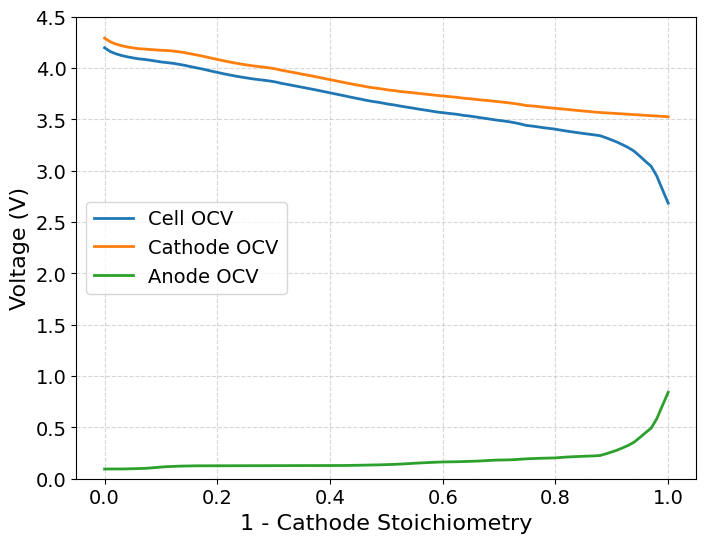

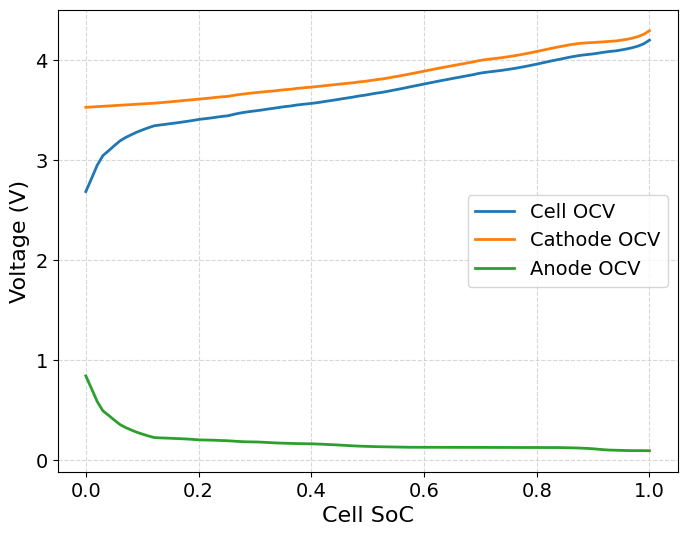

interactive(children=(FloatSlider(value=0.0, description='LAMNE', max=0.5, step=0.01), FloatSlider(value=0.0, …

<function __main__.plot_aging(LAMNE=0.1, LAMPE=0.1, LLI=0.05)>

In [ ]:
# OCV Reconstruction Plots and Interactive Aging Widget
# Notebook imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# -----------------------------------------------------------------------------
# 1. Instantiate your cell
# -----------------------------------------------------------------------------
# Replace the following lines with your actual material definitions
# cath_material = ActiveMaterial(... your cathode data ...)
# an_material   = ActiveMaterial(... your anode data ...)
# np_ratio      = 1.1  # e.g. N:P ratio

cell = CellOCVReconstruction(NCM811_mat, Graphite_mat, np_ratio=1.1, v_min=2.5, v_max=4.2)

# Precompute basic functions and vectors
soc_vec = np.linspace(0, 1, 100)
an0_bol, cath0_bol, an1_bol, cath1_bol =cell.get_stoichiometries()  # This will compute an0, cath0, an1, cath1
# sol_an_fun = lambda x, np_offset=cell.np_offset, np_ratio=cell.np_ratio: (-x + 1 - np_offset) / np_ratio

# # Compute BoL (begin‐of‐life) stoichiometric endpoints
# an0_bol = sol_an_fun(0)
# an1_bol = sol_an_fun(1)
# cath0_bol = 1
# cath1_bol = 0

# Reconstruct voltages (use "discharge" or "charge" as desired)
volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
    an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
)

# -----------------------------------------------------------------------------
# 2. Plot 1: Aligned on (1 - sol_cath)
# -----------------------------------------------------------------------------
x1 = 1 - soc_vec
fig1, ax1 = new_plot()
ax1.plot(x1, volt_cell_bol, label="Cell OCV")
ax1.plot(x1, volt_cath_bol, label="Cathode OCV")
ax1.plot(x1, volt_an_bol, label="Anode OCV")
ax1.set_xlabel("1 - Cathode Stoichiometry")
ax1.set_ylabel("Voltage (V)")
ax1.set_ylim(0, 4.5)
ax1.legend()
plt.show()

# -----------------------------------------------------------------------------
# 3. Plot 2: Aligned on cell SoC
# -----------------------------------------------------------------------------
fig2, ax2 = new_plot()
ax2.plot(soc_vec, volt_cell_bol, label="Cell OCV")
ax2.plot(soc_vec, volt_cath_bol, label="Cathode OCV")
ax2.plot(soc_vec, volt_an_bol, label="Anode OCV")
ax2.set_xlabel("Cell SoC")
ax2.set_ylabel("Voltage (V)")
ax2.legend()
plt.show()

# -----------------------------------------------------------------------------
# 4. Plot 3: Interactive Aging Modes
# -----------------------------------------------------------------------------
def plot_aging(LAMNE=0.1, LAMPE=0.1, LLI=0.05):
    an0_bol, cath0_bol, an1_bol, cath1_bol = cell.get_stoichiometries()
    # BoL curves (dashed)
    volt_cell_bol, volt_cath_bol, volt_an_bol = cell.reconstruct_voltage(
        an0_bol, cath0_bol, an1_bol, cath1_bol, direction="discharge"
    )

    # Aged endpoints & curves
    
    an0_aged, cath0_aged, an1_aged, cath1_aged = cell.simulate_aging_modes(LAMPE, LAMNE, LLI)
    volt_cell_aged, volt_cath_aged, volt_an_aged = cell.reconstruct_voltage(
        an0_aged, cath0_aged, an1_aged, cath1_aged, direction="discharge"
    )

    # Plot
    fig, ax = new_plot()
    # BoL
    ax.plot(x1, volt_cell_bol, "--", label="Cell OCV BoL")
    ax.plot(x1, volt_cath_bol, "--", label="Cathode OCV BoL")
    ax.plot(x1, volt_an_bol, "--", label="Anode OCV BoL")
    # Aged
    ax.plot(x1, volt_cell_aged, label="Cell OCV Aged")
    ax.plot(x1, volt_cath_aged, label="Cathode OCV Aged")
    ax.plot(x1, volt_an_aged, label="Anode OCV Aged")

    ax.set_xlabel("1 - Cathode Stoichiometry")
    ax.set_ylabel("Voltage (V)")
    ax.set_ylim(0, 4.5)
    ax.legend()
    plt.show()

# Widget to vary LAMNE, LAMPE, LLI interactively
interact(
    plot_aging,
    LAMNE=FloatSlider(min=0, max=0.5, step=0.01, value=0.0, description="LAMNE"),
    LAMPE=FloatSlider(min=0, max=0.5, step=0.01, value=0.0, description="LAMPE"),
    LLI=FloatSlider(min=0, max=0.5, step=0.01, value=0.0, description="LLI"),
)
